In [1]:
import sys
sys.path.insert(1, '../GBT_pipeline')
from synthetic import create_true, create_full_cadence, create_false, create_true_single_shot, create_true_faster
import matplotlib.pyplot as plt
import numpy as np 
from single_search import search
from execute_model import model_load
import tensorflow as tf
from numba import njit, jit, prange

@njit(nopython=True)
def pre_proc(data):
#   data= data - data.min()+1
    data = np.log(data)
    data= data - data.min()
    data = data/data.max()
    return data
@jit(parallel=True)
def combine(data):
    new_data = np.zeros((data.shape[0]*data.shape[1],data.shape[2],data.shape[3],data.shape[4]))
    for i in prange(data.shape[0]):
        new_data[i*data.shape[1] : (i+1)*data.shape[1],:,:,:] = data[i,:,:,:,:]
    return new_data

In [29]:
NUM_SAMPLES = 10
factor =1

print("Loading in plate")
plate = np.load('../../filtered.npy')
print("Creating False")

false_data = create_full_cadence(create_false, plate = plate, samples = NUM_SAMPLES, snr_base=5, snr_range=20)
print("Creating True")

true_data = create_full_cadence(create_true_faster, plate = plate, samples = NUM_SAMPLES, snr_base=5, snr_range=20, factor=factor)
print("Creating Single Shot True")

true_single_shot = create_full_cadence(create_true_single_shot, plate = plate, samples = NUM_SAMPLES, snr_base=5, snr_range=20,factor=factor)


Loading in plate
Creating False
0
Creating True
0
Creating Single Shot True
0


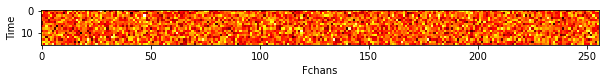

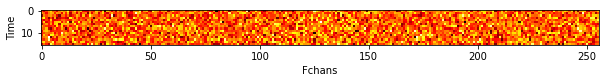

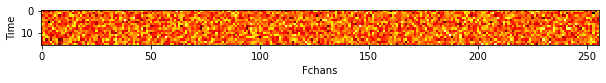

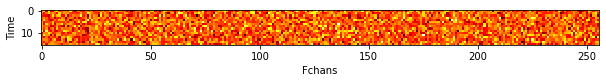

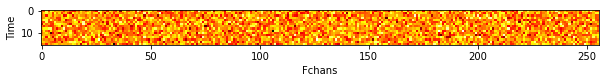

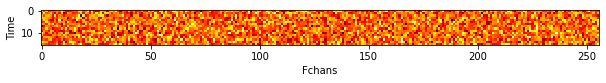

In [30]:
%matplotlib inline
import random 
for i in range(6):
    plt.figure(figsize=(10,4))
    plt.xlabel("Fchans")
    plt.ylabel("Time")
    plt.imshow(false_data[2,i,:,:], interpolation='nearest', cmap=plt.get_cmap('hot'))
    plt.show()

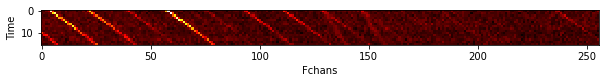

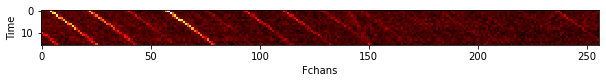

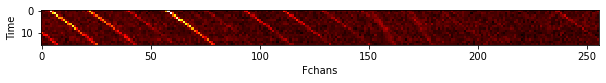

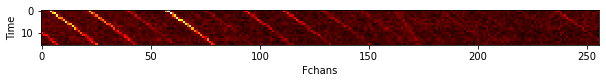

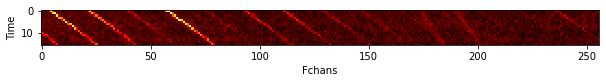

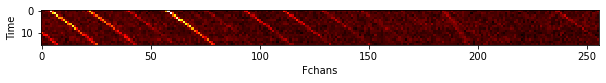

In [31]:
%matplotlib inline
import random 
for i in range(6):
    plt.figure(figsize=(10,4))
    plt.xlabel("Fchans")
    plt.ylabel("Time")
    plt.imshow(true_data[1,i,:,:], interpolation='nearest', cmap=plt.get_cmap('hot'))
    plt.show()

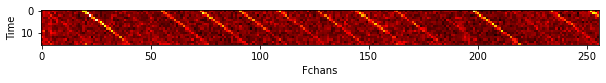

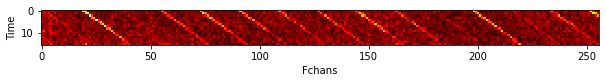

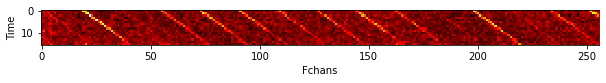

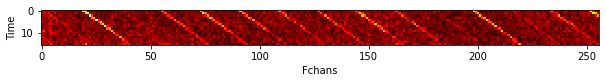

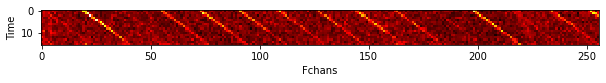

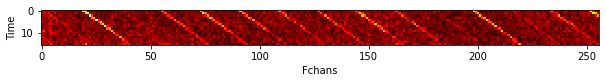

In [32]:
%matplotlib inline
import random 
for i in range(6):
    plt.figure(figsize=(10,4))
    plt.xlabel("Fchans")
    plt.ylabel("Time")
    plt.imshow(true_single_shot[1,i,:,:], interpolation='nearest', cmap=plt.get_cmap('hot'))
    plt.show()

tensorflow      INFO     Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')
tensorflow      WARNING  No training configuration found in the save file, so the model was *not* compiled. Compile it manually.
(10, 6, 16, 256)
Collapse Data
(60, 16, 256, 1)


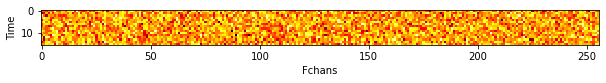

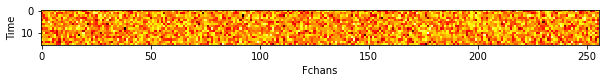

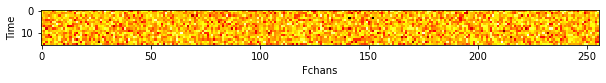

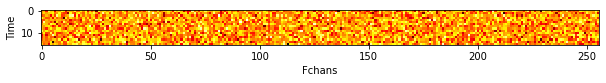

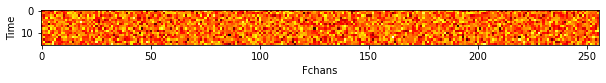

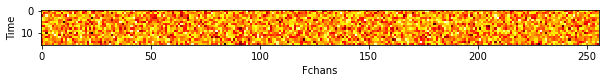

Push Through Neural Net
tensorflow      WARNING  6 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7f207d1b1c80> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
[0 0 0 0 0 0]
[1 0 1 1 0 1]
----------
[0 0 0 0 0 0]
[1 1 1 0 0 0]
----------
[0 0 0 0 0 0]
[0 1 0 1 0 0]
----------
[0 0 0 0 0 0]
[0 0 1 1 0 1]
----------
[0 0 0 0 0 0]
[1 1 1 1 0 0]
----------
[0 0 0 0 0 0]
[0 1 1 1 0 0]
----------

In [40]:
from sklearn.cluster import DBSCAN
from sklearn.cluster import SpectralClustering

%matplotlib inline
model = model_load("VAE-ENCODERv27.h5")
data = pre_proc(abs(false_data))
print(data.shape)
num_samples = data.shape[0]
cadence_length = data.shape[1]
data = data[..., np.newaxis]
print("Collapse Data")
data = combine(data)
print(data.shape)
for i in range(6):
    plt.figure(figsize=(10,4))
    plt.xlabel("Fchans")
    plt.ylabel("Time")
    plt.imshow(data[i,:,:,:], interpolation='nearest', cmap=plt.get_cmap('hot'))
    plt.show()
print("Push Through Neural Net")
result = model.predict(data)[2]

for i in range(NUM_SAMPLES):
    cadence = result[i*6:(i+1)*6]
    clustering  = DBSCAN(eps=0.1, min_samples=2).fit_predict(cadence)
    print(clustering)
    clustering  = SpectralClustering(n_clusters=2, assign_labels="discretize", random_state=0).fit_predict(cadence)
    print(clustering)
    print("----------")


array([0, 1, 0, 1, 0, 1])

In [8]:
i=3
cadence = result[i*6:(i+1)*6]
print(cadence.shape)
print(np.linalg.norm(1/(cadence[0]-cadence[1])))
# print(np.linalg.norm(cadence[0]-cadence[2]))
print(np.linalg.norm(1/(cadence[0]-cadence[3])))
# print(np.linalg.norm(cadence[0]-cadence[4]))
print(np.linalg.norm(1/(cadence[0]-cadence[5])))


print(np.linalg.norm(1/(cadence[2]-cadence[1])))
# print(np.linalg.norm(cadence[0]-cadence[2]))
print(np.linalg.norm(1/(cadence[2]-cadence[3])))
# print(np.linalg.norm(cadence[0]-cadence[4]))
print(np.linalg.norm(1/(cadence[2]-cadence[5])))


print(np.linalg.norm(1/(cadence[4]-cadence[1])))
# print(np.linalg.norm(cadence[0]-cadence[2]))
print(np.linalg.norm(1/(cadence[4]-cadence[3])))
# print(np.linalg.norm(cadence[0]-cadence[4]))
print(np.linalg.norm(1/(cadence[4]-cadence[5])))

print("-----")

print(np.linalg.norm(cadence[0]-cadence[2]))
# print(np.linalg.norm(cadence[0]-cadence[2]))
print(np.linalg.norm(cadence[2]-cadence[4]))
# print(np.linalg.norm(cadence[0]-cadence[4]))
print(np.linalg.norm(cadence[0]-cadence[4]))

print(np.linalg.norm(cadence[1]-cadence[3]))
# print(np.linalg.norm(cadence[0]-cadence[2]))
print(np.linalg.norm(cadence[3]-cadence[5]))
# print(np.linalg.norm(cadence[0]-cadence[4]))
print(np.linalg.norm(cadence[5]-cadence[1]))

(6, 8)
2.8951237
2.913035
2.9207232
2.9306705
2.949339
2.9570959
2.905954
2.9240468
2.9317882
-----
0.039036147
0.035351176
0.0081253415
0.021153975
0.013732105
0.033159375


In [100]:
import tensorflow as tf

a = tf.convert_to_tensor(cadence[0,:], dtype=tf.float64)
b=  tf.convert_to_tensor(cadence[1,:], dtype=tf.float64)
tf.math.reduce_euclidean_norm(a-b, axis=0)

<tf.Tensor: shape=(), dtype=float64, numpy=0.000244204885076682>

In [10]:
model = model_load("VAE-ENCODERv27.h5")
data = pre_proc(abs(false_data))[...,np.newaxis]
print(data.shape)
a1 = tf.convert_to_tensor(model.predict(data[:,0,:,:,:])[2])
b =  tf.convert_to_tensor(model.predict(data[:,1,:,:,:])[2])
a2 =  tf.convert_to_tensor(model.predict(data[:,2,:,:,:])[2])
c =  tf.convert_to_tensor(model.predict(data[:,3,:,:,:])[2])
a3 =  tf.convert_to_tensor(model.predict(data[:,4,:,:,:])[2])
d =  tf.convert_to_tensor(model.predict(data[:,5,:,:,:])[2])


@tf.function
def loss_same(a,b):
    return tf.math.reduce_mean(tf.math.reduce_euclidean_norm(a-b, axis=1))
    
print(loss_same(a1,b))
print(loss_same(a1,c))
print(loss_same(a1,d))

print(loss_same(a2,b))
print(loss_same(a2,c))
print(loss_same(a2,d))

print(loss_same(a3,b))
print(loss_same(a3,c))
print(loss_same(a3,d))

print("----")
print(loss_same(a1,a2))
print(loss_same(a1,a3))
print(loss_same(a2,a3))

print(loss_same(b,c))
print(loss_same(c,d))
print(loss_same(b,d))

tensorflow      INFO     Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')
tensorflow      WARNING  No training configuration found in the save file, so the model was *not* compiled. Compile it manually.
(10, 6, 16, 256, 1)
tf.Tensor(0.0066948147, shape=(), dtype=float32)
tf.Tensor(0.00668336, shape=(), dtype=float32)
tf.Tensor(0.010304037, shape=(), dtype=float32)
tf.Tensor(0.0051131696, shape=(), dtype=float32)
tf.Tensor(0.0027727582, shape=(), dtype=float32)
tf.Tensor(0.005217506, shape=(), dtype=float32)
tf.Tensor(0.0044976473, shape=(), dtype=float32)
tf.Tensor(0.003198449, shape=(), dtype=float32)
tf.Tensor(0.0053137825, shape=(), dtype=float32)
----
tf.Tensor(0.005638771, shape=(), dtype=float32)
tf.Tensor(0.0058222907, shape=(), dtype=float32)
tf.Tensor(0.0027450672, shape=(), dtype=float32)
tf.Tensor(

In [89]:
import tensorflow as tf

a = tf.constant(cadence[0,:], dtype=tf.float64)
b=  tf.constant(cadence[3,:], dtype=tf.float64)
tf.math.reduce_mean(tf.math.reduce_euclidean_norm(a-b, axis=1))

InvalidArgumentError: Invalid reduction dimension (1 for input with 1 dimension(s) [Op:EuclideanNorm]